# Human-level Control through Deep Reinforcement Learning

We analyze the deep Q-learning algorithm devised by the research team of DeepMind. The authors from this paper created their own DQN where the novelty lies in using pixels and scores as input to the neural network compared to lower-dimensional representations, as used in notebook **Naive Deep Q-learning**. For this, they made a shift from simple linear layers to convolutional layers to process the information. Convolutional neural networks perform a mathematical operation called a convolution on the input images. The effect of a convolution is that we start with large-scale images and end up with smaller images that capture the features and paters from that image. The convolution itself is performed by sliding a smaller matrix called a filter over the larger matrix (the input image) and taking the matrix product each time. The resulting numbers are then stored as a new matrix witch will have a smaller size than the original matrix. In reality, we use several filters for each layer. The input image is passed to the first convolutional layer, and the filters are shoved over the image, resulting in smaller matrices. Just like the simple linear layer, we pass the output of our convolutions to an activation function. The smaller activated matrices serve as feature inputs for our regular linear layers.

They tested their algorithm on 49 games from the OpenAI Atari library, and the algorithm was able to outperform all previously created algorithms without hyperparameter tuning. The paper states that reinforcement Learning is unstable when a nonlinear approximator function is used to represents the Q-function. We observed this instability in our own naive implementation of deep Q-learning on the cart-and-pole problem. The agent learns to balance the pole and seemingly for no reason drops its performance. This instability has various root causes. The first reason is that there is a correlation in the sequence of observations. Small updates to the Q-value may drastically change the policy, data distributions, and the correlation between the action-values $Q(s, a)$ and the target value $r + \gamma \max Q(s', a')$. Correlation in the sequence of observations means that the card-and-pole would start in some high-dimensional space, take some action and not leave that region of space. Should the action-value function Q change significantly, we get a significant change in the $r + \gamma \max Q(s', a')$, and we get catapulted to some adjacent region parameter space that our neural network has no information. The second factor is that there is a correlation between the action-value $Q(s, a)$ and the target value $r + \gamma \max Q(s', a')$. Since we use the same network to both select an action and tell us its value, we effectively chase a moving target.

(Mnih et al., 2015) addresses these instabilities with a novel variant of Q-learning witch uses two key ideas. First, they introduce the notion of replay memory that randomizes over the data, thereby removing correlation in the observation sequence and smoothing over changes in the data distribution. Second, they use an iterative update that resolves the action-value $Q(s, a)$ towards the target value $r + \gamma \max Q(s', a')$, which is only periodically updated and thereby reducing correlations with the target. They parametrize the value function $Q(s, a, \theta_i)$ using a deep convolutional neural network in withs $\theta_i$ are the policy network's weights iteration i.

To perform experience replay we store the agents experience $e_t=(s_t,a_t,r_{t+1},s_{t+1})$ at each timestep t in the dataset $D_t=(e_1, e_2, .., e_t)$. We apply Q-learning updates on samples or mini-batches drawn uniformly at random from the pool of stored samples during learning. The uniform sampling guarantees that we do not get a stream of observations from a single episode, and hence we break the correlations.

Our policy neural network gets updated every timestep, as we expect with temporal difference learning, but the target network gets updated only periodically by directly copying the policy neural network's weights. We do not do backpropagation on the target network but only on the policy network.

As mentioned before, this notebook is a replica of the work done in the paper, so we use the same network architecture as proposed. The neural network input consists of an 8 by 84 $\times$ 84 $\times$ image produced by first preprocessing the observation returned by the OpenAI Atari environment. The preprocessing of the observation is not central to the learning, and we invite the reader to consult the GitHub code \cite{GitHub}. The first hidden layer convolves 32 filters of 8 $\times$ 8 with stride 4, followed by a rectified nonlinearity. The second hidden layer convolves 64 filters of 4 $\times$ 4, with side 2, again followed by rectified nonlinearity. This is followed by a third convolutional layer that convolves 64 filters of 3 $\times$ 3 with stride 1 followed by a rectifier. The final hidden layer is fully connected and consists of 512 rectified units. The output layer is a fully-connected layer with a single output for each valid action.

We test our algorithms using the Atari 2600 Pong environment, where the goal is to maximize the score of the Pong game. In this environment, the observation is a two-dimensional array of three-element tuples (RGB). The shape of the array is (210, 160, 3). Each action is repeated four times on every four skipped frames. 

**References:**
- https://gym.openai.com/envs/Pong-v0/
- https://github.com/openai/gym/tree/master/gym/wrappers
- https://github.com/philtabor/Deep-Q-Learning-Paper-To-Code

## Import Libraries

In [1]:
import torch 
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch as T

import gym
import random
import numpy as np

import collections 
import cv2

from ipynb.fs.full.Plotting import *
import matplotlib.pyplot as plt

In [2]:
random.seed(2021)

## Image Preprocessing

In [3]:
# Derives from: Gym.Wrapper.
# Repeating actions over k'th skipped frames and taking max off the previous two frames to overcome flikkering. 

class RepeatAction(gym.Wrapper):
    def __init__(self, env, repeat, clip_reward):
        super(RepeatAction, self).__init__(env)
        
        self.repeat = repeat
        self.clip_reward = clip_reward
        
        self.shape = env.observation_space.low.shape
        self.frame_buffer = np.zeros_like((2, self.shape))

    def step(self, action):
        done = False
        score = 0.0

        # Repeat actions in the environment.
        for i in range(self.repeat):
            observation, reward, done, info = self.env.step(action)
            
            # Clip reward.
            if self.clip_reward:
                reward = np.clip(np.array([reward]), -1, 1)[0]  
            score += reward
            self.frame_buffer[i % 2] = observation
            
            if done:
                break

        max_frame = np.maximum(self.frame_buffer[0], self.frame_buffer[1]) # Return max frame.
        
        return max_frame, score, done, info

    def reset(self):
        observation = self.env.reset()
        self.frame_buffer = np.zeros_like((2,self.shape))
        self.frame_buffer[0] = observation

        return observation

# Derives from: Gym.ObservationWrapper.
# Reshape frame and convert to grayscale.

class PreprocessFrame(gym.ObservationWrapper):
    def __init__(self, env, shape):
        super(PreprocessFrame, self).__init__(env)
        
        self.shape = (shape[2], shape[0], shape[1]) # PyTorch expects image channels first.
        self.observation_space = gym.spaces.Box(low = 0.0, high = 1.0, shape = self.shape, dtype = np.float32)

    def observation(self, observation):
        gray_frame = cv2.cvtColor(observation, cv2.COLOR_RGB2GRAY) # Convert to grayscale.
        resized_frame = cv2.resize(gray_frame, self.shape[1:], interpolation = cv2.INTER_AREA) # Resize frame.
        new_observation = np.array(resized_frame, dtype = np.uint8).reshape(self.shape) # Convert type.
        new_observation = new_observation / 255.0 # RGB ranges from 0 to 255, observation space ranges from 0 to 1.

        return new_observation

# Derives from: Gym.ObservationWrapper.
# Stack frames.

class StackFrames(gym.ObservationWrapper):
    def __init__(self, env, repeat):
        super(StackFrames, self).__init__(env)
        
        self.stack = collections.deque(maxlen = repeat)
        self.observation_space = gym.spaces.Box(env.observation_space.low.repeat(repeat, axis = 0),
                                                env.observation_space.high.repeat(repeat, axis = 0),
                                                dtype = np.float32)
        
    def reset(self):
        observation = self.env.reset()
        self.stack.clear()

        for _ in range(self.stack.maxlen):
            self.stack.append(observation)

        return np.array(self.stack).reshape(self.observation_space.low.shape)

    def observation(self, observation):
        self.stack.append(observation)

        return np.array(self.stack).reshape(self.observation_space.low.shape)

In [4]:
def make_env(env_name, shape = (84, 84, 1), repeat = 4, clip_rewards = False):
    env = gym.make(env_name)
    env = RepeatAction(env, repeat, clip_rewards)
    env = PreprocessFrame(env, shape)
    env = StackFrames(env, repeat)

    return env

## Replay Memory

In [5]:
class ReplayMemory():
    def __init__(self, observation_space, capacity):
        
        self.observation_space = observation_space 
        self.capacity = capacity
        self.replay_counter = 0
        
        self.observation_memory = np.zeros((self.capacity, *self.observation_space), dtype = np.float32)
        self.action_memory = np.zeros(self.capacity, dtype = np.int64)
        self.reward_memory = np.zeros(self.capacity, dtype = np.float32)
        self.next_observation_memory = np.zeros((self.capacity, *self.observation_space), dtype = np.float32)
        self.terminal_memory = np.zeros(self.capacity, dtype = np.bool)

    def store_experience(self, observation, action, reward, next_observation, done):
        index = self.replay_counter % self.capacity
        self.observation_memory[index] = observation
        self.action_memory[index] = action
        self.reward_memory[index] = reward
        self.next_observation_memory[index] = next_observation
        self.terminal_memory[index] = done
        self.replay_counter += 1

    def sample_memory(self, batch_size):
        max_mem = min(self.replay_counter, self.capacity)
        batch = np.random.choice(max_mem, batch_size, replace = False)

        observations = self.observation_memory[batch]
        actions = self.action_memory[batch]
        rewards = self.reward_memory[batch]
        next_observations = self.next_observation_memory[batch]
        terminals = self.terminal_memory[batch]

        return observations, actions, rewards, next_observations, terminals

## Deep Q-network

In [6]:
class DeepQNetwork(nn.Module):
    def __init__(self, observation_space, action_space, learning_rate):
        super(DeepQNetwork, self).__init__()
        
        self.observation_space = observation_space
        self.action_space = action_space
        self.learning_rate = learning_rate

        self.conv1 = nn.Conv2d(self.observation_space[0], 32, 8, stride = 4)
        self.conv2 = nn.Conv2d(32, 64, 4, stride = 2)
        self.conv3 = nn.Conv2d(64, 64, 3, stride = 1)

        self.fc_observation_space = self.calculate_convolutional_output(self.observation_space)

        self.fc1 = nn.Linear(self.fc_observation_space, 512)
        self.fc2 = nn.Linear(512, self.action_space)

        self.optimizer = optim.RMSprop(self.parameters(), lr = self.learning_rate)
        self.device = T.device('cuda:0' if T.cuda.is_available() else 'cpu')
        self.loss = nn.MSELoss()
        self.to(self.device)

    def calculate_convolutional_output(self, observation_space):
        state = T.zeros(1, *observation_space)
        dims = self.conv1(state)
        dims = self.conv2(dims)
        dims = self.conv3(dims)
        return int(np.prod(dims.size()))

    def forward(self, observation):
        conv1 = F.relu(self.conv1(observation))
        conv2 = F.relu(self.conv2(conv1))
        conv3 = F.relu(self.conv3(conv2))
        conv_state = conv3.view(conv3.size()[0], -1) # Conv3 shape is BS x n_filters x H x W.
        flat1 = F.relu(self.fc1(conv_state)) # Conv_state shape is BS x (n_filters * H * W).
        actions = self.fc2(flat1)

        return actions

## Reinforcement Learning Agent

In [7]:
class Agent():
    def __init__(self, observation_space, action_space, learning_rate = 0.0001, discount_rate = 0.99, exploration_rate = 1.0,
                 max_exploration_rate = 1, min_exploration_rate = 0.1, exploration_decay_rate = 0.01,
                 batch_size = 32, replace = 1000, capacity = 50000):
        
        self.episode = 0
        self.learn_counter = 0 
        
        self.observation_space = observation_space
        self.action_space = action_space
        
        self.learning_rate = learning_rate
        self.discount_rate = discount_rate
        
        self.exploration_rate = exploration_rate
        self.max_exploration_rate = max_exploration_rate
        self.min_exploration_rate = min_exploration_rate
        self.exploration_decay_rate = exploration_decay_rate
        
        self.batch_size = batch_size
        self.replace = replace
        self.capacity = capacity
        
        self.replay_memory = ReplayMemory(self.observation_space, self.capacity)
        self.policy_network = DeepQNetwork(self.observation_space, self.action_space, self.learning_rate)
        self.target_network = DeepQNetwork(self.observation_space, self.action_space, self.learning_rate)
        
    def choice_action(self, observation):
        exploration_rate_threshold = np.random.random()
        if exploration_rate_threshold > self.exploration_rate:
            observation = T.tensor([observation], dtype = T.float).to(self.policy_network.device)
            actions = self.policy_network.forward(observation) # Q-values for action in state.
            action = T.argmax(actions).item() # Best Q-value for action in state.
        else:
            action = np.random.choice(self.action_space) # Random Action.
            
        return action
    
    def store_experience(self, observation, action, reward, next_observation, done):
        self.replay_memory.store_experience(observation, action, reward, next_observation, done)

    def sample_memory(self):
        observations, actions, rewards, next_observations, terminals = self.replay_memory.sample_memory(self.batch_size)
        
        return observations, actions, rewards, next_observations, terminals

    def replace_target_network(self):
        if self.learn_counter % self.replace == 0:
            self.target_network.load_state_dict(self.policy_network.state_dict())
            
    def decrease_exploration_rate(self):
        self.exploration_rate = self.min_exploration_rate + \
            (self.max_exploration_rate - self.min_exploration_rate) * np.exp(- self.exploration_decay_rate * self.episode)
        self.episode += 1

    def learn(self):
        if self.replay_memory.replay_counter < self.batch_size:
            return
        
        # Increment learn counter.
        self.learn_counter += 1
        
        # Set gradient to zero.
        self.policy_network.optimizer.zero_grad()
        
        # Copy policy network to target network after.
        self.replace_target_network()

        # Sample from replay memory.
        observations, actions, rewards, next_observations, terminals = self.sample_memory()
        
        # Convert to tensors.
        observations = T.tensor(observations).to(self.policy_network.device)
        actions = T.tensor(actions).to(self.policy_network.device)
        rewards = T.tensor(rewards).to(self.policy_network.device)
        next_observations = T.tensor(next_observations).to(self.policy_network.device)
        terminals = T.tensor(terminals).to(self.policy_network.device)
        
        indices = np.arange(self.batch_size)

        # Calculate loss using Bellman equation.
        q_pred = self.policy_network.forward(observations)[indices, actions]
        q_next = self.target_network.forward(next_observations).max(dim = 1)[0]
        q_next[terminals] = 0.0
        q_target = rewards + self.discount_rate * q_next
        loss = self.policy_network.loss(q_target, q_pred).to(self.policy_network.device)
        
        # Optimizer in action.
        loss.backward()
        self.policy_network.optimizer.step()

## Main Program

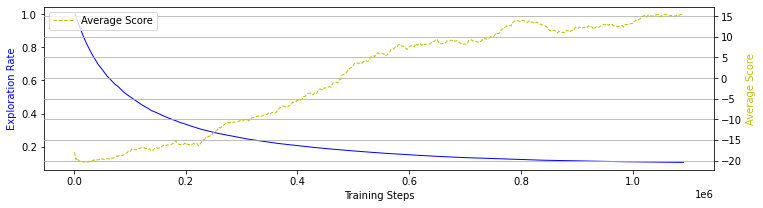

In [9]:
step = 0
episodes = 500

env = make_env('PongNoFrameskip-v4')
agent = Agent(env.observation_space.shape, env.action_space.n)

scores, exploration_rate_history, steps = [], [], []

for i in range(episodes):
    observation = env.reset()
    done = False
    score = 0.0
    
    while not done:
        action = agent.choice_action(observation)
        next_observation, reward, done, info = env.step(action)
        agent.store_experience(observation, action, reward, next_observation, done)
        agent.learn()
        observation = next_observation
        score += reward
        step += 1
    
    scores.append(score)
    steps.append(step)
    exploration_rate_history.append(agent.exploration_rate)
    agent.decrease_exploration_rate()

plot_learning_curve(steps, scores, exploration_rate_history)

The agent starts to learn as the epsilon decreases, but the majority of the learning happens in the greedy face. By around 500.000 steps, the agent has topped out its score with some oscillation around 15.5 or 16. We manage this with only a few hours of training on modest hardware. 